<a href="https://colab.research.google.com/github/nickalden90/NBA-Shot-Data/blob/main/Contour_Shot_Charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '2023-24-nba-leaders-shot-details:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5676246%2F9361704%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240910%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240910T184141Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2d68a1f45cfae5e7effed40835208dd71fbbc8dda721c5995140ab2a3b3625e65a32021595d06eebb7165baa53ed254eaabc5ec566e512b28af3ebacce4a55f96acc504406fef14ff62941ac1572edcb5483ad079426dd61f3de3619cfef08e522935fdc25b91c10b4eec1e8b6771a9819846e71bc9a15a82ef98a113a170c4f25d1c15faf7f45a3a4439f7acf6a9a15ba9c14d229cfcac53a46c0468817d9cf5a7a4705e7deb0a3cb16d32151be5c5c200f46a5c662d755ef89de6ac0fab83fab9b7a630cf280162cd690c165103d61a5119ed64184782ed2432f2e69fe0e224ff14528b0427e5d2c915debf214aff809614928ee7f6edc1b7a3cb52f010e2d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
from os import path
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [ ]:
shots = pd.read_csv('/kaggle/input/2023-24-nba-leaders-shot-details/shots2324.csv')
court_img = mpimg.imread('/kaggle/input/2023-24-nba-leaders-shot-details/court_outline.png')

In [ ]:
import warnings
warnings.filterwarnings("ignore")

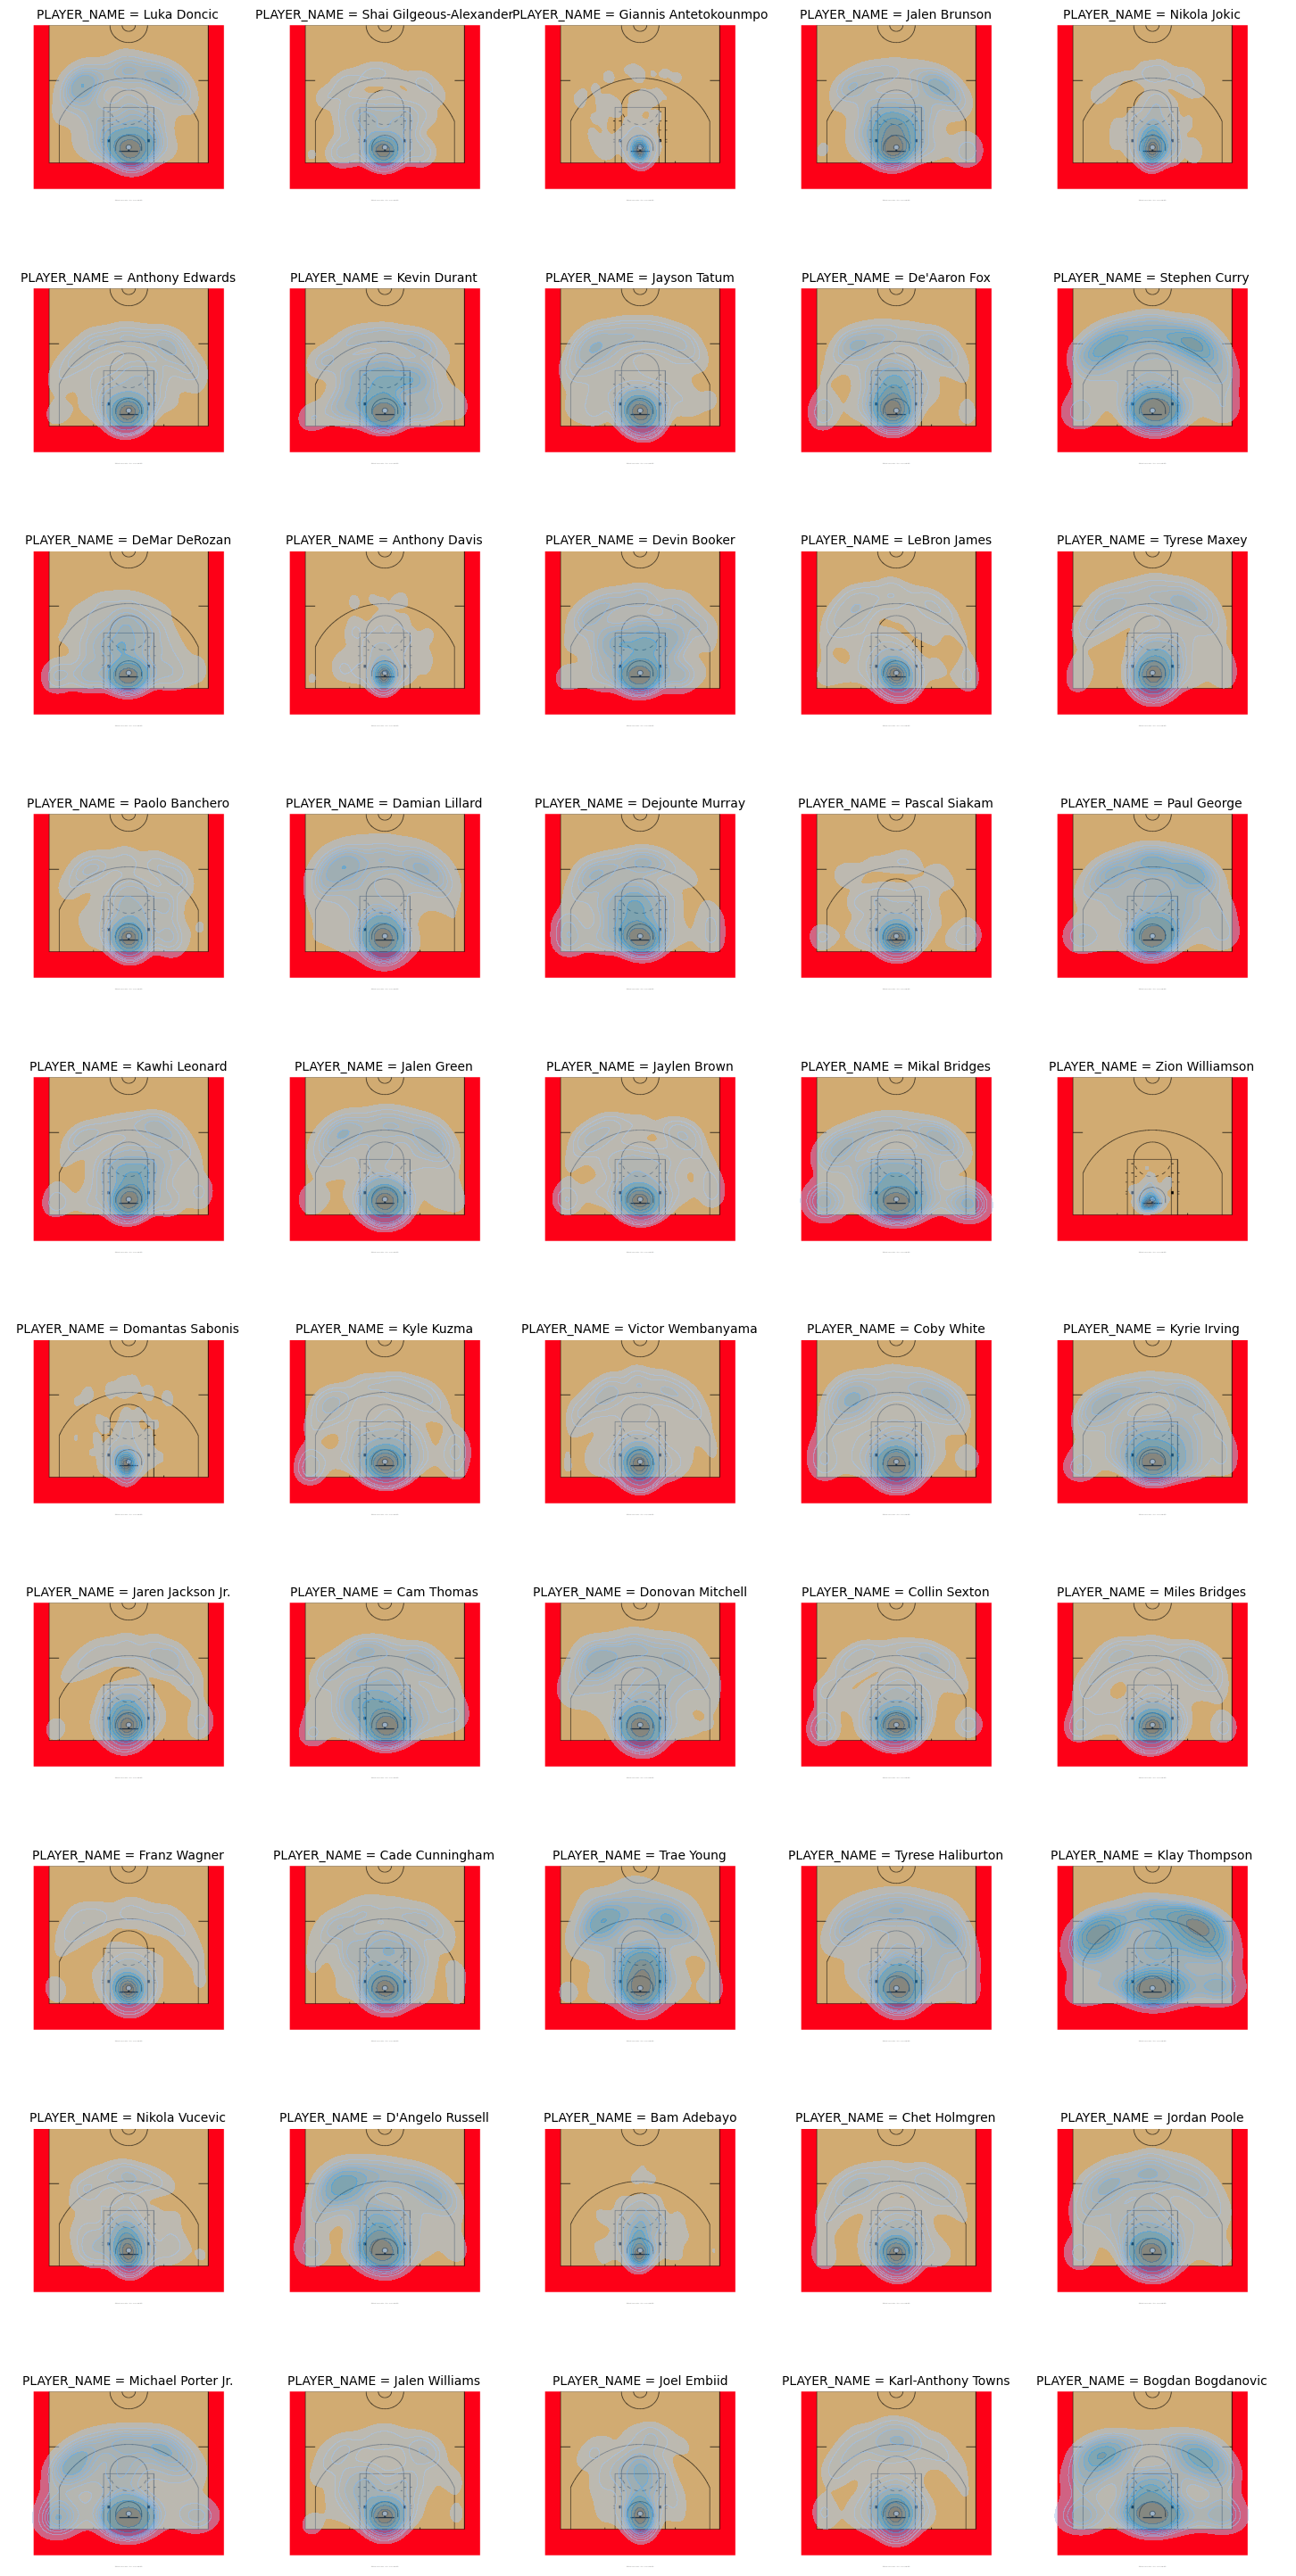

In [ ]:
pd.option_context('mode.use_inf_as_na', True)
g = (sns.FacetGrid(shots, col='PLAYER_NAME', col_wrap=5).
     map(sns.kdeplot, 'LOC_X', 'LOC_Y', alpha=0.5, fill=True).add_legend())
g.set(yticks=[], xticks=[], xlabel=None, ylabel=None)
g.despine(left=True, bottom=True)

for ax in g.fig.axes:
    ax.imshow(court_img, zorder=0, extent=[-380, 380, -150, 410])
pd.option_context('mode.use_inf_as_na', True)

plt.savefig('ContourShotCharts_2324.png')